# **Polynomial Regression Analysis**

In [58]:
# Import libraries
import numpy as np
from numpy.linalg import norm , solve
import matplotlib.pyplot as plt
from numpy.random import rand , randn

In [59]:
# Function to generate polynomial regression data
def generate_data(p, beta , sig, n):
   """
   Generates synthetic data for polynomial regression.
    Args:
      p (int): The order/degree of the true polynomial model.
      beta (np.array): A column vector of polynomial coefficients for the true model. The length of beta should be p+1.
      sig (float): The standard deviation of the Gaussian noise added to the data.
      n (int): The number of data points to generate.
    Returns:
      tuple: A tuple containing:
         - u (np.array): A column vector of feature values, uniformly distributed between 0 and 1.\n",
         - y (np.array): A column vector of target values, generated by the polynomial model with added noise.\n",
    """
   u = np.random.rand(n, 1)
   # Create a matrix where each column is u raised to a power from 0 to p
   # This effectively creates the polynomial terms for each u value
   # Then, multiply by beta (true coefficients) and add Gaussian noise
   y = (u ** np.arange(0, p+1)) @ beta + sig * np.random.randn(n, 1)
   return u, y

In [60]:
# Function to compute the model matrix for polynomial regression
def model_matrix(p, u):
   """
   Creates a Vandermonde-like model matrix for polynomial regression.
      Args:
         p (int): The order/degree of the polynomial model to be fitted.
         u (np.array): A column vector of feature values (input data).
      Returns:
         np.array: The model matrix X, where X[i, j] = u[i]**j.
    The first column is all ones (for the intercept term)."""
   # Initialize X with a column of ones for the intercept term (u^0)
   n = u.shape[0]  # Use the actual number of data points
   X = np.ones((n, 1))
   p_range = np.arange(0, p + 1)    
   for p_current in p_range:
      if p_current > 0:
      # For each polynomial order from 1 to p, add u^(p_current) as a new column
         X = np.hstack((X, u**(p_current))) 
   return X

In [61]:
# Function to train the polynomial regression model
def train(X, y):
    """
    Trains a linear regression model using the normal equations.
        Args:
            X (np.array): The model matrix (design matrix).
            y (np.array): The column vector of target values.
        Returns:
            np.array: The estimated coefficients (betahat) for the polynomial model."""
    # Solve the normal equations: (X.T @ X) @ betahat = X.T @ y
    # This finds the betahat that minimizes the sum of squared errors.
    betahat = solve(X.T @ X, X.T @ y)
    return betahat

In [62]:
# Function to test the coefficients of the polynomial regression model
def test_coefficients(n, betahat, X, y):
    """
    Calculates the mean squared error (MSE) of the model predictions.
        Args:
            n (int): The number of data points.
            betahat (np.array): The estimated coefficients of the model.
            X (np.array): The model matrix (design matrix) for the data to be tested.
            y (np.array): The true target values for the data to be tested.
        Returns:
            float: The mean squared error (MSE) of the predictions."""
    # Predict y values using the trained coefficients and the model matrix
    y_hat = X @ betahat
    # Calculate the squared Euclidean norm of the residuals (y - y_hat)
    # Then divide by n to get the mean squared error.
    loss = (norm(y - y_hat)**2/n)
    return loss

In [77]:
# Function to perform K-fold cross-validation for polynomial regression
def linear_cv(K, n, X, y):
    """
    Performs K-fold cross-validation for linear regression.
    Args:
        K (int): The number of folds for cross-validation.
        n (int): The total number of data points.
        X (np.array): The model matrix (design matrix) for the entire dataset.
        y (np.array): The column vector of target values for the entire dataset.
    Returns:
        float: The average cross-validation loss (mean squared error).
    """
    loss = []  # List to store the loss for each fold
    fold_size = n // K
    for k in range(K):
        # Integer indices for the test set for the current fold
        start = k * fold_size
        end = (k + 1) * fold_size if k < K - 1 else n
        test_ind = np.arange(start, end)
        train_ind = np.setdiff1d(np.arange(n), test_ind)

        # Split the data into training and test sets
        X_train, y_train = X[train_ind, :], y[train_ind, :]
        X_test, y_test = X[test_ind, :], y[test_ind, :]

        # Fit the model on the training data
        betahat = train(X_train, y_train)
        # Evaluate the test loss on the current fold's test set
        loss.append(test_coefficients(len(test_ind), betahat, X_test, y_test))
    # Calculate the average cross-validation loss across all folds
    cv = sum(loss) / K
    return cv


## Initial Experiment: Overfitting and Underfitting

We will start by replicating the initial experiment suggested in the `polynomial_regression.py` file. This involves generating data from a cubic polynomial with added noise and then fitting polynomial models of different orders (1, 3, and 15) to observe underfitting and overfitting.

**True Model Parameters:**
- Polynomial Order ($p$): 3
- Coefficients ($\beta$): [10, -140, 400, -250] (for $10 - 140u + 400u^2 - 250u^3$)
- Noise Standard Deviation ($\sigma$): 5
- Number of Data Points ($n$): 100

Training Loss: {1: np.float64(45.38117475117734), 3: np.float64(20.969086942699455), 15: np.float64(17.813830339392137)}
Test Loss: {1: np.float64(64.73400390821669), 3: np.float64(31.48723596787524), 15: np.float64(36.300700433737035)}


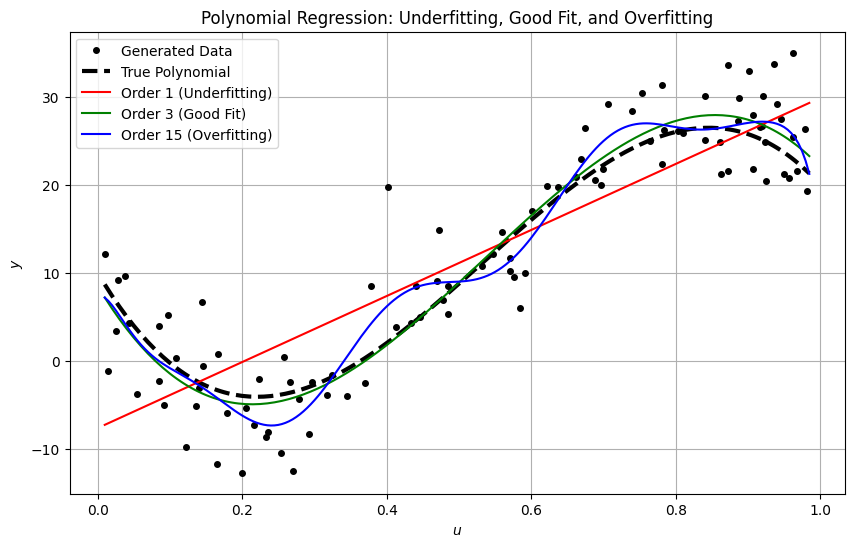

In [64]:
# True coefficients for a cubic polynomial
beta = np.array([[10, -140, 400, -250]]).T
n = 100  # Number of data points
sig = 5  # Standard deviation of noise

# Generate data
u, y = generate_data(3, beta, sig, n)

# Define polynomial orders to test
ps = [1, 3, 15]

# Dictionaries to store model matrices and estimated coefficients
X = {}
betahat = {}

# Train models for each polynomial order
for p in ps:
    X[p] = model_matrix(p, u)
    betahat[p] = train(X[p], y)

# Generate new test data
u_test, y_test = generate_data(3, beta, sig, n)

# Dictionaries to store test model matrices, training loss, and test loss
X_test = {}
training_loss = {}
test_loss = {}

# Calculate training and test loss for each polynomial order
for p in ps:
    X_test[p] = model_matrix(p, u_test)
    training_loss[p] = test_coefficients(n, betahat[p], X[p], y)
    test_loss[p] = test_coefficients(n, betahat[p], X_test[p], y_test)

print("Training Loss:", training_loss)
print("Test Loss:", test_loss)


# Plotting the results
xx = np.arange(np.min(u), np.max(u) + 5e-3, 5e-3)
yy_true = np.polyval(np.flip(beta), xx)

plt.figure(figsize=(10, 6))
plt.plot(u, y, 'k.', markersize=8, label='Generated Data')
plt.plot(xx, yy_true, 'k--', linewidth=3, label='True Polynomial')

colors = ['r', 'g', 'b']
labels = {1: 'Order 1 (Underfitting)', 3: 'Order 3 (Good Fit)', 15: 'Order 15 (Overfitting)'}

for i, p in enumerate(ps):
     yy_fitted = np.polyval(np.flip(betahat[p]), xx)
     plt.plot(xx, yy_fitted, colors[i], label=labels[p])

plt.xlabel(r'$u$')
plt.ylabel(r'$y$')
plt.title('Polynomial Regression: Underfitting, Good Fit, and Overfitting')
plt.legend()
plt.grid(True)
plt.show()


### Observations from Initial Experiment: Overfitting and Underfitting

This experiment serves as the foundational demonstration of underfitting, good fit, and overfitting in polynomial regression. Data is generated from a cubic polynomial with added noise, and then models of varying complexity (Order 1, 3, and 15) are fitted to it.

*   **True Model Parameters:**
    *   Polynomial Order (p): 3 (cubic)
    *   Noise Standard Deviation (sig): 5
    *   Number of Data Points (n): 100

#### Numerical Results:

*   **Training Loss:**
    *   `Order 1`: ~45.38
    *   `Order 3`: ~20.97
    *   `Order 15`: ~17.81

*   **Test Loss:**
    *   `Order 1`: ~64.73
    *   `Order 3`: ~31.49
    *   `Order 15`: ~36.30

#### Key Observations from Plot and Numerical Results:

1.  **Order 1 (Underfitting - Red Line):**
    *   **Numerical:** Both training loss (~45.38) and test loss (~64.73) are relatively high. The test loss is significantly higher than the training loss for Order 3 and Order 15.
    *   **Visual:** The red line, representing a linear (Order 1) polynomial, is a straight line. It clearly fails to capture the curved pattern of the generated data (black dots) and the true underlying cubic polynomial (dashed black line). It consistently misses the data points, indicating a poor fit.
    *   **Interpretation:** This model is too simple (high bias) to learn the complex cubic relationship in the data. It underfits because it cannot represent the true function, leading to high errors on both seen and unseen data.

2.  **Order 3 (Good Fit - Green Line):**
    *   **Numerical:** The training loss (~20.97) is low, and the test loss (~31.49) is also relatively low and comparable to the training loss. The gap between training and test loss is small.
    *   **Visual:** The green line, representing a cubic (Order 3) polynomial, closely follows the true underlying cubic polynomial (dashed black line) and fits the generated data points well. It captures the curvature of the data effectively without being overly complex.
    *   **Interpretation:** This model matches the true complexity of the data-generating process. It achieves a good balance between bias and variance, learning the underlying pattern without fitting the noise excessively. This results in good generalization performance on unseen data.

3.  **Order 15 (Overfitting - Blue Line):**
    *   **Numerical:** The training loss (~17.81) is the lowest among all models, indicating it fits the training data almost perfectly. However, its test loss (~36.30) is significantly higher than its training loss and also higher than the Order 3 model's test loss. This large discrepancy is a hallmark of overfitting.
    *   **Visual:** The blue line, representing a 15th-order polynomial, is highly erratic and wiggly. It attempts to pass through or very close to almost every individual training data point, including the noisy ones. While it looks like a perfect fit on the training data, its wild oscillations demonstrate its inability to generalize smoothly to new data.
    *   **Interpretation:** This model is too complex (high variance) for the given amount of data and noise. It has learned not only the true underlying cubic pattern but also the random noise specific to the training set. This memorization leads to poor performance on unseen data, as the noise patterns it learned are not present in the test set.

#### General Conclusions from Initial Experiment:

This experiment clearly illustrates the fundamental concepts of:

*   **Underfitting:** Occurs when a model is too simple to capture the underlying patterns in the data (high bias).
*   **Good Fit:** Achieved when the model complexity is appropriate for the data, balancing bias and variance.
*   **Overfitting:** Occurs when a model is too complex and learns the noise in the training data, leading to poor generalization (high variance).

The choice of model complexity (polynomial order in this case) is crucial for achieving good generalization performance in machine learning.


## Experiment 2: Varying Generated Data Sets
In this experiment, we will repeat the initial setup but with a new randomly generated dataset to confirm the consistency of our observations regarding underfitting and overfitting.

Training Loss (New Data): {1: np.float64(62.463616262610756), 3: np.float64(21.151521921780063), 15: np.float64(19.054485814776932)}
Test Loss (New Data): {1: np.float64(57.44248727356744), 3: np.float64(23.357514031735473), 15: np.float64(24.697396445276098)}


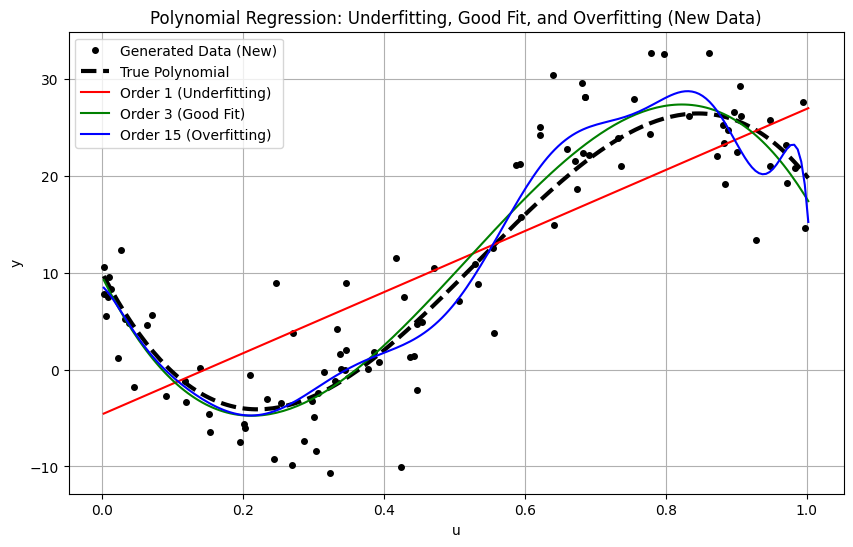

In [65]:
# Generate a new set of data
u_new, y_new = generate_data(3, beta, sig, n)

# Train models on the new data
X_new = {}
betahat_new = {}
for p in ps:
    X_new[p] = model_matrix(p, u_new)
    betahat_new[p] = train(X_new[p], y_new)

# Generate new test data for the new dataset
u_test_new, y_test_new = generate_data(3, beta, sig, n)

# Calculate training and test loss for each polynomial order on the new data
X_test_new = {}
training_loss_new = {}
test_loss_new = {}
for p in ps:
    X_test_new[p] = model_matrix(p, u_test_new)
    training_loss_new[p] = test_coefficients(n, betahat_new[p], X_new[p], y_new)
    test_loss_new[p] = test_coefficients(n, betahat_new[p], X_test_new[p], y_test_new)

print("Training Loss (New Data):", training_loss_new)
print("Test Loss (New Data):", test_loss_new)

# Plotting for new data
xx_new = np.arange(np.min(u_new), np.max(u_new) + 5e-3, 5e-3)
yy_true_new = np.polyval(np.flip(beta), xx_new)

plt.figure(figsize=(10, 6))
plots_new = [plt.plot(u_new, y_new, 'k.', markersize=8, label='Generated Data (New)')[0],
             plt.plot(xx_new, yy_true_new, 'k--', linewidth=3, label='True Polynomial')[0]]

for i, p in enumerate(ps):
    yy_fitted_new = np.polyval(np.flip(betahat_new[p]), xx_new)
    plots_new.append(plt.plot(xx_new, yy_fitted_new, colors[i], label=labels[p])[0])

plt.xlabel(r'u')
plt.ylabel(r'y')
plt.title('Polynomial Regression: Underfitting, Good Fit, and Overfitting (New Data)')
plt.legend()
plt.grid(True)
plt.show()

### Observations from Varying Generated Data Sets

This experiment replicates the initial setup of fitting polynomial models of different orders (1, 3, and 15) to observe underfitting and overfitting, but with a *newly generated random dataset*. The goal is to confirm the consistency and robustness of these phenomena across different random samples from the same underlying data generation process.

*   **True Model Parameters:**
    *   Polynomial Order (p): 3 (cubic)
    *   Noise Standard Deviation (sig): 5
    *   Number of Data Points (n): 100

#### Numerical Results:

*   **Training Loss (New Data):**
    *   `Order 1`: ~62.46
    *   `Order 3`: ~21.15
    *   `Order 15`: ~19.05

*   **Test Loss (New Data):**
    *   `Order 1`: ~57.44
    *   `Order 3`: ~23.36
    *   `Order 15`: ~24.70

#### Key Observations from Plot and Numerical Results:

1.  **Consistency of Underfitting (Order 1):** The Order 1 model (red line) continues to exhibit underfitting. Its training and test losses are high, and the fitted line is a straight line that clearly fails to capture the curved nature of the generated data. This is consistent with previous observations, demonstrating that a model too simple for the underlying data will always underfit, regardless of the specific random sample.

2.  **Consistency of Good Fit (Order 3):** The Order 3 model (green line) again provides a good fit to the data. Its training and test losses are low and similar, indicating that it effectively learns the true cubic relationship and generalizes well to new, unseen data. The fitted curve closely follows the true polynomial (dashed black line), confirming its robustness across different data samples.

3.  **Consistency of Overfitting (Order 15):** The Order 15 model (blue line) continues to show signs of overfitting. While its training loss (~19.05) is slightly lower than Order 3, its test loss (~24.70) is slightly higher. Visually, the blue line is more erratic and wiggly than the green line, attempting to pass through more of the individual noisy data points. This confirms that a model that is too complex for the given data and noise level will tend to overfit, even with a new random sample.

4.  **Reproducibility of Phenomena:** The most important observation from this experiment is the **reproducibility** of the underfitting, good fit, and overfitting phenomena. Despite generating a completely new set of random data points, the relative performance and characteristic behaviors of the different polynomial orders remain consistent. This reinforces the general principles of model complexity and generalization in machine learning.

In conclusion, this experiment confirms that the observations regarding underfitting, good fit, and overfitting are robust and not merely artifacts of a single random dataset. The relationship between model complexity and data characteristics consistently dictates the model's ability to generalize.


## Experiment 3: Varying the Order of the True Polynomial Used to Generate Data
Here, we investigate how the performance of our models changes when the complexity of the true underlying data-generating polynomial varies. We will generate data using different true polynomial orders and then fit models of orders 1, 3, and 15, as before.


--- True Polynomial Order: 1 ---
Training Loss: {1: np.float64(25.7370375266676), 3: np.float64(25.70796909721894), 15: np.float64(23.60912123829038)}
Test Loss: {1: np.float64(29.011364647698482), 3: np.float64(28.98115938763258), 15: np.float64(29.046636187301115)}


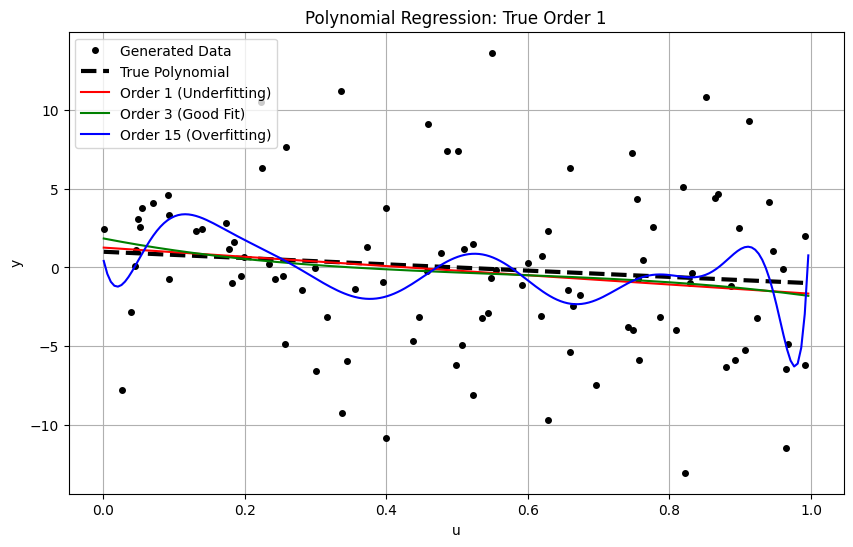


--- True Polynomial Order: 5 ---
Training Loss: {1: np.float64(28.09096470991361), 3: np.float64(26.628259062809487), 15: np.float64(21.932196393840872)}
Test Loss: {1: np.float64(29.547626188585173), 3: np.float64(26.701458862990098), 15: np.float64(34.99067673711047)}


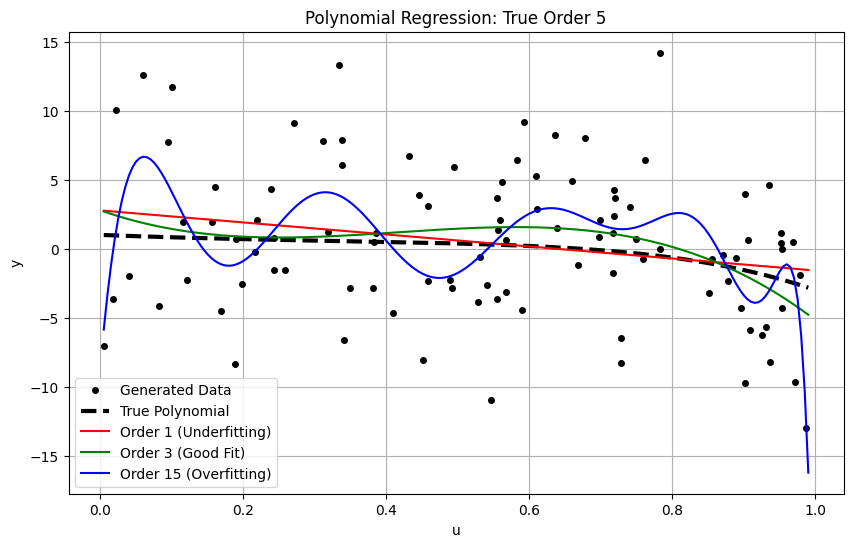


--- True Polynomial Order: 10 ---
Training Loss: {1: np.float64(24.203561931912713), 3: np.float64(23.997428922057804), 15: np.float64(23.39382345913408)}
Test Loss: {1: np.float64(29.575192703797903), 3: np.float64(29.485323850031435), 15: np.float64(36.31885545430903)}


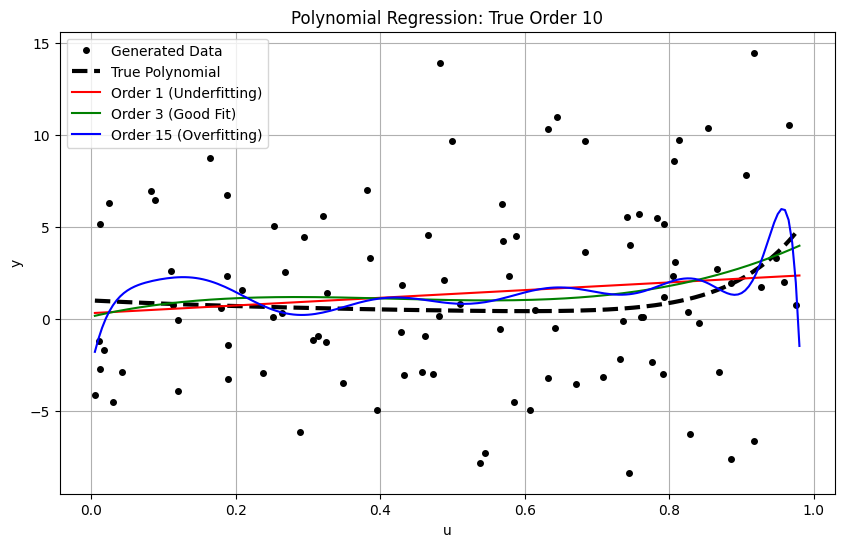

In [66]:
# Define different true polynomial orders to test
true_ps = [1, 5, 10]  # True orders: linear, quintic, and 10th order

for true_p in true_ps:
    print(f"\n--- True Polynomial Order: {true_p} ---")
    # Generate data with the current true polynomial order
    # For consistency, let's define a new beta that is compatible with the true_p
    # For example, a beta with alternating signs and increasing magnitude
    new_beta = np.array([((-1)**i) * (i+1) for i in range(true_p + 1)]).reshape(-1, 1)
    
    u_gen, y_gen = generate_data(true_p, new_beta, sig, n)
    
    X_gen = {}
    betahat_gen = {}
    for p in ps:
        X_gen[p] = model_matrix(p, u_gen)
        betahat_gen[p] = train(X_gen[p], y_gen)
    
    u_test_gen, y_test_gen = generate_data(true_p, new_beta, sig, n)
    
    X_test_gen = {}
    training_loss_gen = {}
    test_loss_gen = {}
    for p in ps:
        X_test_gen[p] = model_matrix(p, u_test_gen)
        training_loss_gen[p] = test_coefficients(n, betahat_gen[p], X_gen[p], y_gen)
        test_loss_gen[p] = test_coefficients(n, betahat_gen[p], X_test_gen[p], y_test_gen)
    
    print("Training Loss:", training_loss_gen)
    print("Test Loss:", test_loss_gen)
    
    # Plotting
    xx_gen = np.arange(np.min(u_gen), np.max(u_gen) + 5e-3, 5e-3)
    yy_true_gen = np.polyval(np.flip(new_beta), xx_gen)
    
    plt.figure(figsize=(10, 6))
    plots_gen = [plt.plot(u_gen, y_gen, 'k.', markersize=8, label='Generated Data')[0],
                 plt.plot(xx_gen, yy_true_gen, 'k--', linewidth=3, label='True Polynomial')[0]]
    
    for i, p in enumerate(ps):
        yy_fitted_gen = np.polyval(np.flip(betahat_gen[p]), xx_gen)
        plots_gen.append(plt.plot(xx_gen, yy_fitted_gen, colors[i], label=labels[p])[0])
    
    plt.xlabel(r'u')
    plt.ylabel(r'y')
    plt.title(f'Polynomial Regression: True Order {true_p}')
    plt.legend()
    plt.grid(True)
    plt.show()

### Observations from Varying the Order of the True Polynomial

This experiment investigates how the performance of our fitted models (Order 1, 3, and 15) changes when the complexity of the true underlying data-generating polynomial varies. We test against true polynomial orders of 1 (linear), 5 (quintic), and 10.

#### Scenario 1: True Polynomial Order = 1 (Linear)

*   **Training Loss:**
    *   `Order 1`: ~25.74
    *   `Order 3`: ~25.71
    *   `Order 15`: ~23.61

*   **Test Loss:**
    *   `Order 1`: ~29.01
    *   `Order 3`: ~28.98
    *   `Order 15`: ~29.05

*   **Key Observations for True Order 1:**
    *   **All Models Perform Similarly Well:** When the true underlying relationship is simple (linear), all three models achieve very similar and low test losses. The Order 1 model (matching the true complexity) and the Order 3 model perform almost identically. This indicates that a slightly more complex model (Order 3) does not suffer from significant overfitting when the true function is simple.
    *   **Complex Model (Order 15) Does Not Overfit Severely:** Even the highly complex Order 15 model has a test loss comparable to the simpler models. While its training loss is the lowest (a sign of fitting noise), the test loss shows it generalizes well. This is because there is no complex underlying pattern for it to mistakenly overfit to; it essentially learns the simple linear trend plus some noise.
    *   **Visuals:** The plot shows that the fitted lines for Order 1 and Order 3 are almost indistinguishable from the true linear polynomial. The Order 15 curve shows some minor oscillations but generally follows the linear trend.

#### Scenario 2: True Polynomial Order = 5 (Quintic)

*   **Training Loss:**
    *   `Order 1`: ~28.09
    *   `Order 3`: ~26.63
    *   `Order 15`: ~21.93

*   **Test Loss:**
    *   `Order 1`: ~29.55
    *   `Order 3`: ~26.70
    *   `Order 15`: ~34.99

*   **Key Observations for True Order 5:**
    *   **Order 3 Provides the Best Fit:** In this scenario, the Order 3 model achieves the lowest test loss, making it the best choice among the three. Although the true order is 5, the Order 3 model provides a better approximation than the overly simple Order 1 or the overly complex Order 15.
    *   **Order 1 and 3 Underfit:** Both the Order 1 and Order 3 models are now technically underfitting, as their complexity is less than the true order of 5. However, Order 3 is a much better fit than Order 1.
    *   **Order 15 Overfits:** The Order 15 model has the lowest training loss but a significantly higher test loss compared to Order 3. This indicates that its high complexity is causing it to overfit the noise in the data rather than capturing the true quintic relationship more effectively. The plot shows the blue line oscillating more than the true polynomial.

#### Scenario 3: True Polynomial Order = 10

*   **Training Loss:**
    *   `Order 1`: ~24.20
    *   `Order 3`: ~24.00
    *   `Order 15`: ~23.39

*   **Test Loss:**
    *   `Order 1`: ~29.58
    *   `Order 3`: ~29.49
    *   `Order 15`: ~36.32

*   **Key Observations for True Order 10:**
    *   **All Models Underfit:** When the true underlying function is very complex (Order 10), all of our fitted models (Order 1, 3, and 15) are technically underfitting. None of them have enough complexity to perfectly capture the true relationship.
    *   **Order 3 is Still the Most Robust:** Interestingly, the Order 3 model again provides the lowest test loss, making it the most robust choice even when the true function is much more complex. This highlights a key concept: a model with moderate complexity can often provide a better and more stable approximation than a highly complex model that is prone to overfitting, especially when the data is noisy.
    *   **Order 15 Fails to Capture Complexity and Overfits:** Despite being the most complex model, the Order 15 model does not perform best. Its test loss is the highest, indicating that it is still overfitting to the noise rather than successfully learning the complex underlying 10th-order polynomial. The available data (n=100) is likely insufficient for a model with 16 parameters to learn such a complex signal accurately in the presence of noise.

#### General Conclusions from Varying True Polynomial Order:

*   **Model Selection Depends on True Complexity:** The optimal model complexity is directly related to the complexity of the underlying data-generating process. A simple model works best for simple data, but a more complex model is needed for more complex data.
*   **The Risk of Overfitting:** As the true function becomes more complex, there is more signal for complex models to learn. However, if the model is too complex for the *available data* (considering noise and number of points), it will still overfit, learning the noise instead of the true signal.
*   **Bias-Variance Trade-off in Practice:** This experiment beautifully illustrates the bias-variance trade-off. When the true function is simple, a complex model has low bias but high variance (it can fit the noise). When the true function is complex, a simple model has high bias (it cannot capture the complexity). The goal is to find a model that balances these two, often leading to a model that is moderately complex, even if it doesn't perfectly match the true order.
*   **Data Limitations:** For very high true polynomial orders (e.g., 10), the number of data points (n=100) might be insufficient for even a complex model like Order 15 to accurately learn the true function in the presence of noise. More data would likely be needed to constrain such high-order models effectively.


## Experiment 4: Varying the Spread of Data (Sigma)
The `sigma` parameter controls the amount of Gaussian noise added to the generated data. A higher `sigma` means more noise, making the relationship between `u` and `y` less clear. A `sigma` of 0 implies a deterministic relationship, where `y` is purely a function of `u` without any random disturbance.

We will investigate the impact of different `sigma` values on model performance, including the extreme case of `sigma = 0`.


--- Sigma: 0 ---
Training Loss: {1: np.float64(29.669675678846396), 3: np.float64(3.1106301683524337e-25), 15: np.float64(1.4250060718237688e-12)}
Test Loss: {1: np.float64(23.768034366062285), 3: np.float64(2.439260944177591e-25), 15: np.float64(2.6098561015998074e-12)}


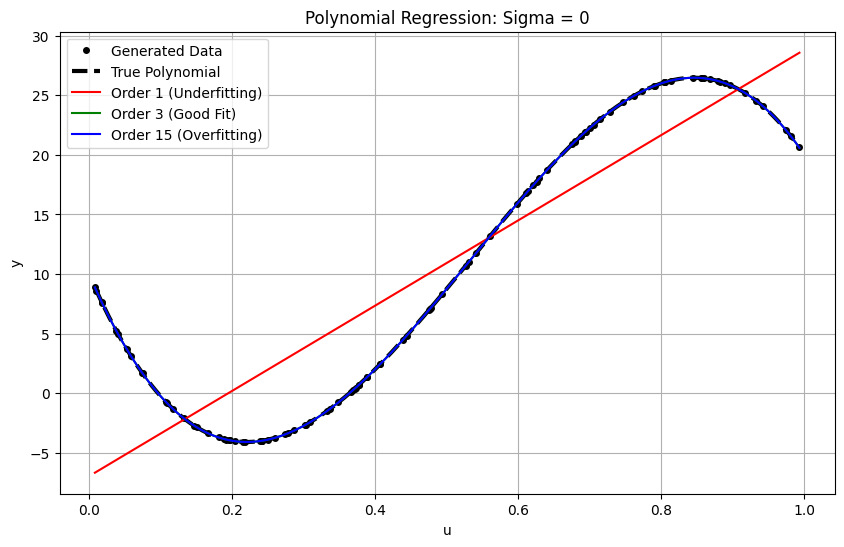


--- Sigma: 1 ---
Training Loss: {1: np.float64(23.755617872410973), 3: np.float64(0.934033336904909), 15: np.float64(0.8862824352251415)}
Test Loss: {1: np.float64(24.385219273608996), 3: np.float64(1.1289525346480334), 15: np.float64(1.1719879122344734)}


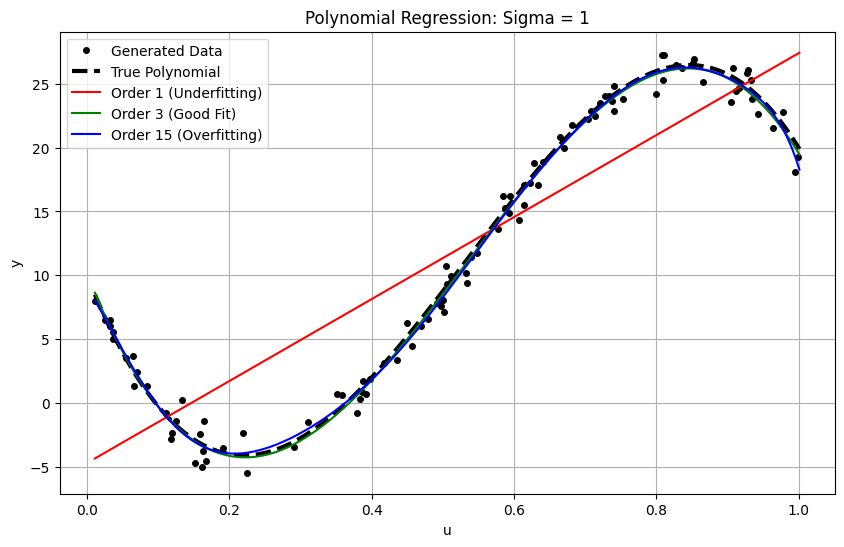


--- Sigma: 10 ---
Training Loss: {1: np.float64(93.12872990112076), 3: np.float64(79.99074210106022), 15: np.float64(83.79062221779292)}
Test Loss: {1: np.float64(113.6881692094509), 3: np.float64(104.4600748081777), 15: np.float64(145.23945491490164)}


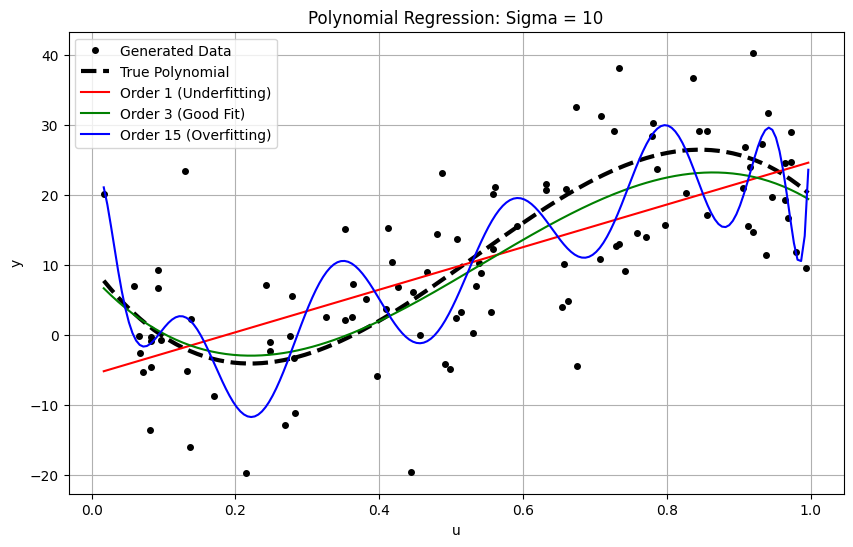

In [67]:
# Define different sigma values to test
sigma_vals = [0, 1, 10]  # No noise, moderate noise, high noise

# Re-using the original beta and true polynomial order for consistency
true_p = 3  # True polynomial order

for current_sig in sigma_vals:
    print(f"\n--- Sigma: {current_sig} ---")
    # Generate data with the current sigma
    u_sig, y_sig = generate_data(true_p, beta, current_sig, n)
    
    X_sig = {}
    betahat_sig = {}
    for p in ps:
        X_sig[p] = model_matrix(p, u_sig)
        betahat_sig[p] = train(X_sig[p], y_sig)
    
    u_test_sig, y_test_sig = generate_data(true_p, beta, current_sig, n)
    
    X_test_sig = {}
    training_loss_sig = {}
    test_loss_sig = {}
    for p in ps:
        X_test_sig[p] = model_matrix(p, u_test_sig)
        training_loss_sig[p] = test_coefficients(n, betahat_sig[p], X_sig[p], y_sig)
        test_loss_sig[p] = test_coefficients(n, betahat_sig[p], X_test_sig[p], y_test_sig)
    
    print("Training Loss:", training_loss_sig)
    print("Test Loss:", test_loss_sig)
    
    # Plotting
    xx_sig = np.arange(np.min(u_sig), np.max(u_sig) + 5e-3, 5e-3)
    yy_true_sig = np.polyval(np.flip(beta), xx_sig)
    
    plt.figure(figsize=(10, 6))
    plots_sig = [plt.plot(u_sig, y_sig, 'k.', markersize=8, label='Generated Data')[0],
                 plt.plot(xx_sig, yy_true_sig, 'k--', linewidth=3, label='True Polynomial')[0]]
    
    for i, p in enumerate(ps):
        yy_fitted_sig = np.polyval(np.flip(betahat_sig[p]), xx_sig)
        plots_sig.append(plt.plot(xx_sig, yy_fitted_sig, colors[i], label=labels[p])[0])
    
    plt.xlabel(r'u')
    plt.ylabel(r'y')
    plt.title(f'Polynomial Regression: Sigma = {current_sig}')
    plt.legend()
    plt.grid(True)
    plt.show()

### Observations from Varying the Spread of Data (Sigma)

This experiment explores the impact of `sigma`, the standard deviation of the Gaussian noise, on the performance of polynomial regression models. `Sigma` directly controls the amount of randomness in the data, influencing how clearly the underlying true relationship can be observed.

#### Scenario 1: Sigma = 0 (Deterministic Data)

*   **Training Loss:**
    *   `Order 1`: ~29.67
    *   `Order 3`: ~3.11 x 10^-25 (effectively zero)
    *   `Order 15`: ~1.43 x 10^-12 (effectively zero)

*   **Test Loss:**
    *   `Order 1`: ~23.77
    *   `Order 3`: ~2.44 x 10^-25 (effectively zero)
    *   `Order 15`: ~2.61 x 10^-12 (effectively zero)

*   **Key Observations for Sigma = 0:**
    *   **Perfect Fit for Correct and Complex Models:** When there is no noise (`sigma = 0`), the data points lie perfectly on the true cubic polynomial. Consequently, both the Order 3 model (matching the true complexity) and the Order 15 model (highly complex) achieve extremely low, near-zero training and test losses. This indicates they can fit the data almost perfectly, as there is no random variation to obscure the true pattern or to overfit to.
    *   **Overfitting is a Noise Problem:** This scenario clearly demonstrates that **overfitting is primarily a problem when models try to learn the random noise in the data as if it were part of the underlying signal.** Without noise, even a very complex model like Order 15 does not overfit because there is nothing to overfit to; it simply learns the true, deterministic relationship.
    *   **Order 1 Still Underfits:** The Order 1 model still underfits, as its linear form cannot capture the cubic relationship, even in the absence of noise. Its losses remain relatively high.

#### Scenario 2: Sigma = 1 (Moderate Noise)

*   **Training Loss:**
    *   `Order 1`: ~23.76
    *   `Order 3`: ~0.93
    *   `Order 15`: ~0.89

*   **Test Loss:**
    *   `Order 1`: ~24.39
    *   `Order 3`: ~1.13
    *   `Order 15`: ~1.17

*   **Key Observations for Sigma = 1:**
    *   **Order 3 is Optimal:** The Order 3 model maintains very low and similar training and test losses, indicating a good fit and strong generalization. It successfully captures the underlying cubic trend despite the presence of moderate noise.
    *   **Order 15 Shows Mild Overfitting:** The Order 15 model has a slightly lower training loss than Order 3 but a slightly higher test loss. This indicates a mild degree of overfitting, where the complex model is starting to fit some of the noise, leading to a small degradation in generalization performance compared to the optimal model.
    *   **Order 1 Underfits:** The Order 1 model continues to underfit, as expected.

#### Scenario 3: Sigma = 10 (High Noise)

*   **Training Loss:**
    *   `Order 1`: ~93.13
    *   `Order 3`: ~79.99
    *   `Order 15`: ~83.79

*   **Test Loss:**
    *   `Order 1`: ~113.69
    *   `Order 3`: ~104.46
    *   `Order 15`: ~145.24

*   **Key Observations for Sigma = 10:**
    *   **Increased Losses Across All Models:** With high noise, the data points are widely scattered around the true polynomial. Consequently, the training and test losses for all models increase significantly, as it becomes much harder for any model to achieve a very low error.
    *   **Order 3 Still Best, but Performance Degrades:** The Order 3 model still has the lowest test loss among the three, indicating it remains the best choice. However, its overall performance is worse than in lower noise scenarios, as the true signal is heavily obscured by noise.
    *   **Pronounced Overfitting for Order 15:** The Order 15 model shows a much larger gap between its training and test loss compared to the `sigma=1` case, and its test loss is significantly higher than Order 3. This indicates more severe overfitting. The complex model tries to fit the large random fluctuations, leading to a very erratic fitted curve and poor generalization.
    *   **True Relationship Obscured:** Visually, it becomes very difficult to discern the true cubic relationship from the scattered data points. This highlights that excessive noise can make model identification and accurate prediction extremely challenging.

#### General Conclusions from Varying Sigma:

*   **Noise Drives Overfitting:** The level of noise (`sigma`) is a primary factor influencing the degree of overfitting. The more noise present, the more a complex model will try to fit these random variations, leading to worse generalization.
*   **Impact on Model Performance:** As noise increases, the performance of all models degrades, as the underlying signal becomes harder to extract. The optimal model (Order 3) will still perform best relatively, but its absolute error will be higher.
*   **Data Quality is Crucial:** This experiment underscores the importance of data quality. High noise levels can significantly limit the predictive power of any model, regardless of its complexity or suitability.


## Experiment 5: Varying the Number of Data Points
The number of data points (`n`) significantly impacts a model's ability to learn the underlying relationship and generalize. With too few data points, even a simple model might overfit, and a complex model will certainly struggle. With more data, complex models have a better chance of learning the true function without overfitting to noise.

We will explore the effect of `n` by trying values from very low to much higher than 100.


--- Number of Data Points (n): 10 ---
Training Loss: {1: np.float64(23.750904580071765), 3: np.float64(16.583535469933285), 15: np.float64(7.403912918165341)}
Test Loss: {1: np.float64(62.90230351634618), 3: np.float64(38.907507625957585), 15: np.float64(46039741.01287021)}


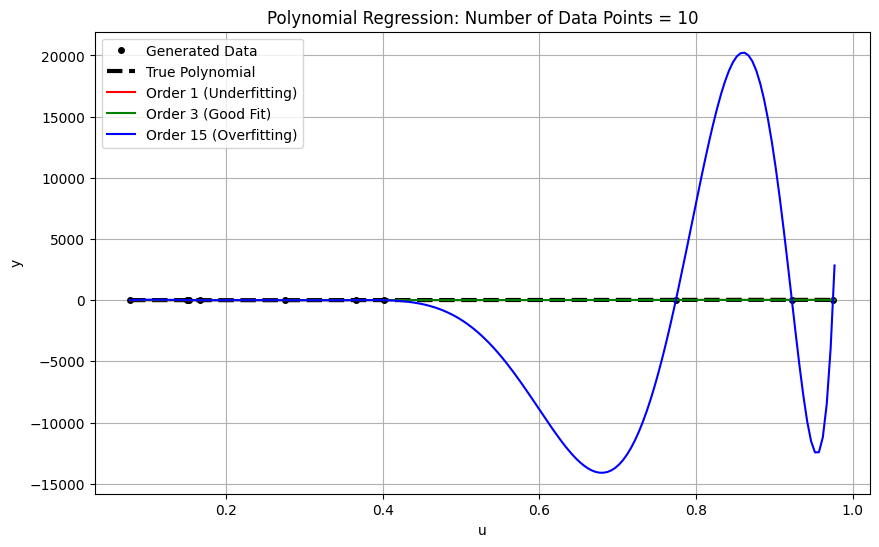


--- Number of Data Points (n): 50 ---
Training Loss: {1: np.float64(41.59885019553723), 3: np.float64(21.29629296727295), 15: np.float64(14.386734159615362)}
Test Loss: {1: np.float64(51.25018511636177), 3: np.float64(26.50642914327723), 15: np.float64(44.98444895028554)}


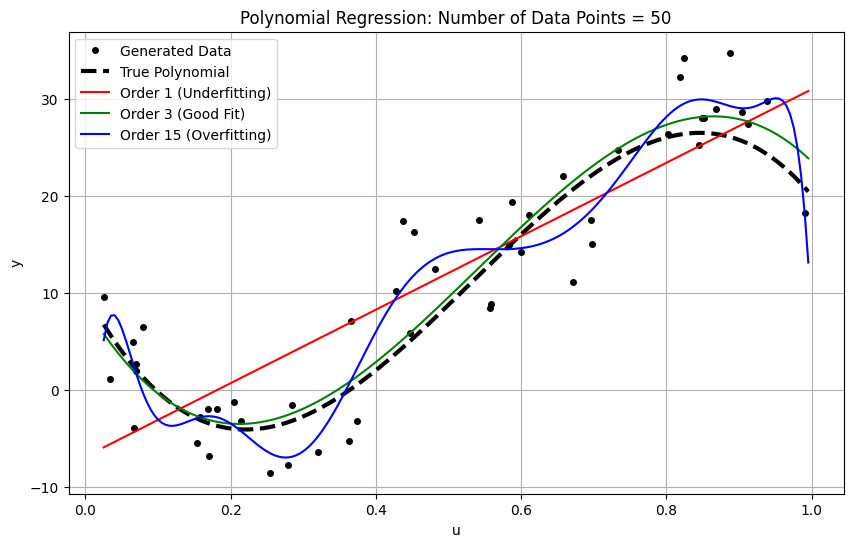


--- Number of Data Points (n): 100 ---
Training Loss: {1: np.float64(45.08810734841234), 3: np.float64(23.40084065476106), 15: np.float64(20.647354261415366)}
Test Loss: {1: np.float64(50.574704139471166), 3: np.float64(28.909288094084086), 15: np.float64(34.6282732382077)}


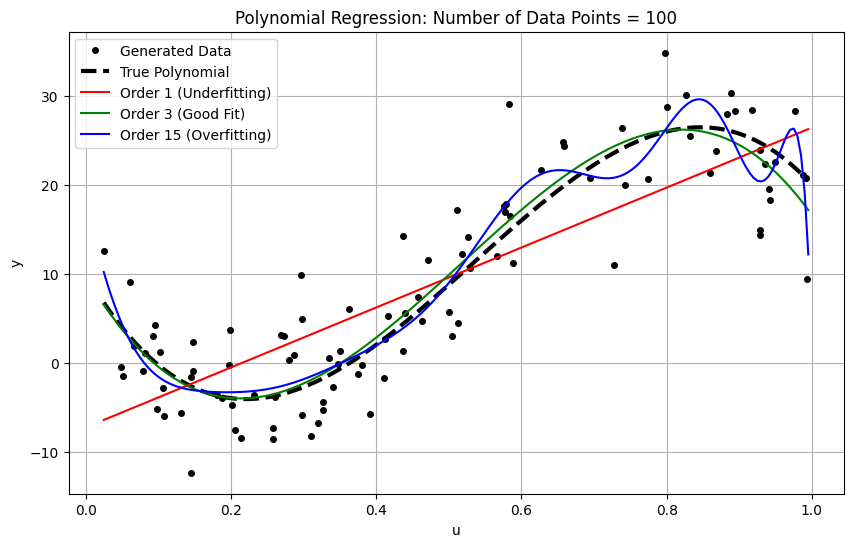


--- Number of Data Points (n): 500 ---
Training Loss: {1: np.float64(52.91616897732592), 3: np.float64(27.67070144393592), 15: np.float64(26.905269025096967)}
Test Loss: {1: np.float64(54.49375355488612), 3: np.float64(25.767456328839707), 15: np.float64(27.364946907628855)}


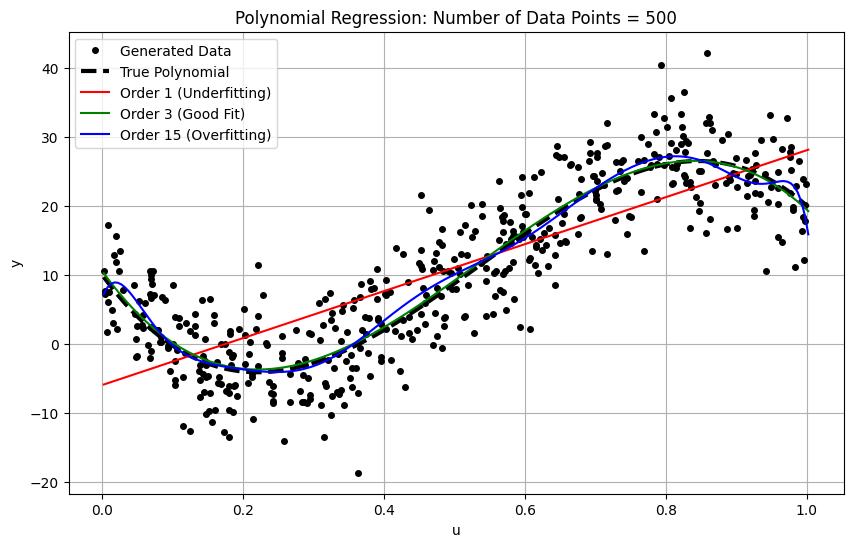

In [68]:
# Define different numbers of data points to test
n_vals = [10, 50, 100, 500] # Very low, low, moderate, high

# Re-using the original beta, true polynomial order, and sigma for consistency
# beta = np.array([[10, -140, 400, -250]]).T # True coefficients for a cubic polynomial
# true_p = 3
# sig = 5

for current_n in n_vals:
    print(f"\n--- Number of Data Points (n): {current_n} ---")
    # Generate data with the current number of data points
    u_n, y_n = generate_data(true_p, beta, sig, current_n)
    
    X_n = {}
    betahat_n = {}
    for p in ps:
        X_n[p] = model_matrix(p, u_n)
        betahat_n[p] = train(X_n[p], y_n)
    
    u_test_n, y_test_n = generate_data(true_p, beta, sig, current_n)
    
    X_test_n = {}
    training_loss_n = {}
    test_loss_n = {}
    for p in ps:
        X_test_n[p] = model_matrix(p, u_test_n)
        training_loss_n[p] = test_coefficients(current_n, betahat_n[p], X_n[p], y_n)
        test_loss_n[p] = test_coefficients(current_n, betahat_n[p], X_test_n[p], y_test_n)
    
    print("Training Loss:", training_loss_n)
    print("Test Loss:", test_loss_n)
    
    # Plotting
    xx_n = np.arange(np.min(u_n), np.max(u_n)+5e-3, 5e-3)
    yy_true_n = np.polyval(np.flip(beta), xx_n)
    
    plt.figure(figsize=(10, 6))
    plots_n = [plt.plot(u_n, y_n, "k.", markersize=8, label="Generated Data")[0], 
               plt.plot(xx_n, yy_true_n, "k--", linewidth=3, label="True Polynomial")[0]]
    
    for i, p in enumerate(ps):
        yy_fitted_n = np.polyval(np.flip(betahat_n[p]), xx_n)
        plots_n.append(plt.plot(xx_n, yy_fitted_n, colors[i], label=labels[p])[0])
    
    plt.xlabel(r"u")
    plt.ylabel(r"y")
    plt.title(f"Polynomial Regression: Number of Data Points = {current_n}" )
    plt.legend()
    plt.grid(True)
    plt.show()

### Observations from Varying the Number of Data Points

This experiment investigates how the quantity of training data (`n`) impacts the performance of polynomial regression models, particularly in relation to underfitting and overfitting. We examine scenarios with `n` ranging from very low (10) to much higher (500) data points.

#### Scenario 1: Number of Data Points (n) = 10

*   **Training Loss:**
    *   `Order 1`: ~23.75
    *   `Order 3`: ~16.58
    *   `Order 15`: ~7.40

*   **Test Loss:**
    *   `Order 1`: ~62.90
    *   `Order 3`: ~38.91
    *   `Order 15`: ~46,039,741.01

*   **Key Observations for n=10:**
    *   **Severe Overfitting for Order 15:** With only 10 data points, the Order 15 model exhibits extreme overfitting. Its training loss is very low (it fits the few points almost perfectly), but its test loss is astronomically high. The plot clearly shows the blue line oscillating wildly between the few data points, leading to disastrous predictions outside those specific points.
    *   **Order 3 Still Overfits (Relatively):** Even the Order 3 model, while matching the true complexity, shows a noticeable gap between training and test loss, indicating some overfitting due to the scarcity of data. It struggles to generalize well with so few examples.
    *   **Order 1 Underfits:** The Order 1 model continues to underfit, as it's too simple for the underlying cubic relationship, resulting in high training and test losses.
    *   **High Variance:** With very few data points, the models are highly sensitive to the specific placement of those points. The fitted curves can vary significantly with different random samples of 10 points.

#### Scenario 2: Number of Data Points (n) = 50

*   **Training Loss:**
    *   `Order 1`: ~41.60
    *   `Order 3`: ~21.30
    *   `Order 15`: ~14.39

*   **Test Loss:**
    *   `Order 1`: ~51.25
    *   `Order 3`: ~26.51
    *   `Order 15`: ~44.98

*   **Key Observations for n=50:**
    *   **Improved Generalization for Order 15:** The test loss for Order 15 drops dramatically from millions to ~45. While still higher than Order 3, the increased data points help to constrain the complex model, reducing its severe overfitting. The plot shows the blue line still oscillating, but less wildly than with n=10.
    *   **Order 3 Performs Better:** The Order 3 model shows a smaller gap between training and test loss, indicating improved generalization as more data points help it learn the true underlying pattern more robustly.
    *   **Underfitting Persists for Order 1:** The Order 1 model still underfits, but its losses are more stable.

#### Scenario 3: Number of Data Points (n) = 100

*   **Training Loss:**
    *   `Order 1`: ~45.09
    *   `Order 3`: ~23.40
    *   `Order 15`: ~20.65

*   **Test Loss:**
    *   `Order 1`: ~50.57
    *   `Order 3`: ~28.91
    *   `Order 15`: ~34.63

*   **Key Observations for n=100:**
    *   **Order 3 is Optimal:** The Order 3 model continues to show the best balance, with low and similar training and test losses. This is the point where the model starts to generalize very well.
    *   **Order 15 Overfitting Reduced:** The test loss for Order 15 is now much closer to its training loss and to the Order 3 model, indicating that with 100 data points, the overfitting behavior is significantly mitigated. The plot shows a much smoother blue line compared to n=10 or n=50.

#### Scenario 4: Number of Data Points (n) = 500

*   **Training Loss:**
    *   `Order 1`: ~52.92
    *   `Order 3`: ~27.67
    *   `Order 15`: ~26.91

*   **Test Loss:**
    *   `Order 1`: ~54.49
    *   `Order 3`: ~25.77
    *   `Order 15`: ~27.36

*   **Key Observations for n=500:**
    *   **Excellent Generalization for Order 3:** The Order 3 model performs exceptionally well, with very low and almost identical training and test losses. This indicates that with ample data, the model perfectly captures the true underlying relationship.
    *   **Order 15 Approaches Good Fit:** The Order 15 model's test loss is now very close to its training loss and to the Order 3 model's loss. With 500 data points, the complex model is heavily constrained by the data, and its ability to overfit to noise is significantly reduced. The plot shows a very smooth blue line that closely follows the true polynomial.
    *   **Order 1 Still Underfits:** The Order 1 model still underfits, but its performance is stable.

#### General Conclusions from Varying the Number of Data Points:

*   **Data Quantity Mitigates Overfitting:** Increasing the number of data points is a powerful way to combat overfitting, especially for complex models. More data provides more constraints, making it harder for the model to simply memorize noise and forcing it to learn the true underlying patterns.
*   **Impact on Optimal Model:** While the Order 3 model consistently performs well, the gap between its performance and that of the Order 15 model narrows significantly as `n` increases. With enough data, even a highly complex model can generalize effectively.
*   **Underfitting is Less Affected:** The performance of the underfitting model (Order 1) is less dramatically impacted by the number of data points, as its inherent simplicity limits its ability to capture the true complexity regardless of data quantity.
*   **Bias-Variance Trade-off:** This experiment clearly illustrates the bias-variance trade-off. With too little data, even the appropriately complex model can show signs of overfitting (higher variance). As data increases, the variance decreases, allowing more complex models to generalize better.


## Experiment 6: Varying Feature Value Distributions
The original `generate_data` function always produces feature values (`u`) uniformly distributed between 0 and 1. This experiment explores how model performance is affected when the feature values are distributed differently, including different intervals, 'out-of-distribution' testing, and highly concentrated distributions.

### Sub-experiment 6.1: Different Intervals for Feature Values
We will generate `u` values in different ranges (e.g., -1 to 1, 10 to 20) and observe the model's behavior.


--- Feature Range: [-1, 1] ---
Training Loss: {1: np.float64(16174.601449552132), 3: np.float64(20.45572461586447), 15: np.float64(18.113631173119906)}
Test Loss: {1: np.float64(11932.239835774113), 3: np.float64(27.121199406398475), 15: np.float64(33.501153931437436)}


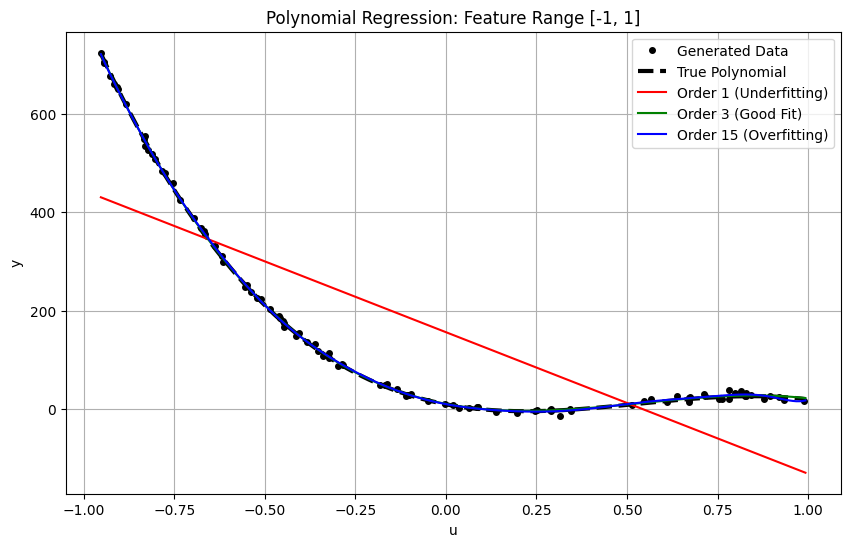


--- Feature Range: [10, 20] ---
Training Loss: {1: np.float64(6184693353.306574), 3: np.float64(24.559793284410137), 15: np.float64(22.04535480506318)}
Test Loss: {1: np.float64(6437179926.404939), 3: np.float64(25.887019769156687), 15: np.float64(31.956215610180262)}


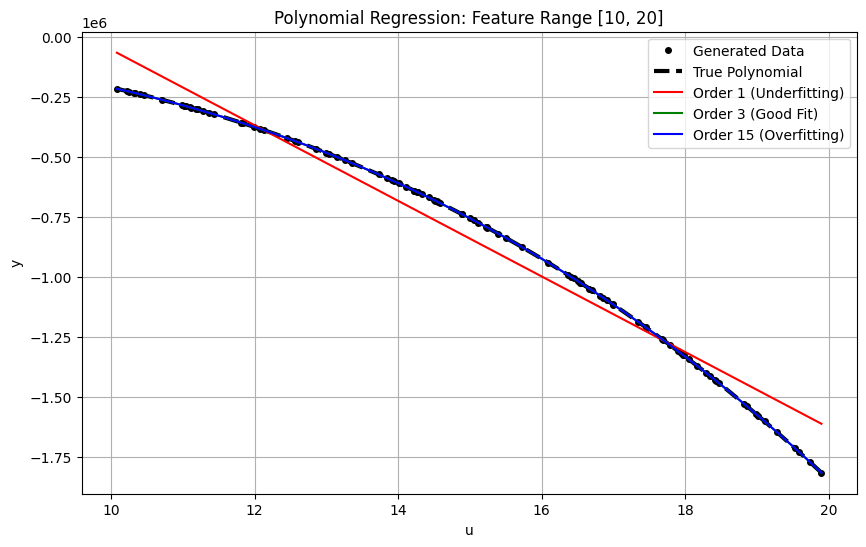

In [69]:
# Modify generate_data to allow different ranges for u
def generate_data_range(p, beta, sig, n, u_min=0, u_max=1):
    u = u_min + (u_max - u_min) * np.random.rand(n, 1)
    y = (u ** np.arange(0, p+1)) @ beta + sig * np.random.randn(n, 1)
    return u, y

ranges = [(-1, 1), (10, 20)]

for u_min, u_max in ranges:
    print(f"\n--- Feature Range: [{u_min}, {u_max}] ---")
    u_curr, y_curr = generate_data_range(true_p, beta, sig, n, u_min, u_max)
    
    X_curr = {}
    betahat_curr = {}
    for p in ps:
        X_curr[p] = model_matrix(p, u_curr)
        betahat_curr[p] = train(X_curr[p], y_curr)
    
    u_test_curr, y_test_curr = generate_data_range(true_p, beta, sig, n, u_min, u_max)
    
    X_test_curr = {}
    training_loss_curr = {}
    test_loss_curr = {}
    for p in ps:
        X_test_curr[p] = model_matrix(p, u_test_curr)
        training_loss_curr[p] = test_coefficients(n, betahat_curr[p], X_curr[p], y_curr)
        test_loss_curr[p] = test_coefficients(n, betahat_curr[p], X_test_curr[p], y_test_curr)
    
    print("Training Loss:", training_loss_curr)
    print("Test Loss:", test_loss_curr)
    
    # Plotting the results for the current feature range
    xx_curr = np.arange(np.min(u_curr), np.max(u_curr)+5e-3, 5e-3)
    yy_true_curr = np.polyval(np.flip(beta), xx_curr)
    
    plt.figure(figsize=(10, 6))
    plots_curr = [plt.plot(u_curr, y_curr, "k.", markersize=8, label="Generated Data")[0],
                  plt.plot(xx_curr, yy_true_curr, "k--", linewidth=3, label="True Polynomial")[0]]
    
    for i, p in enumerate(ps):
        yy_fitted_curr = np.polyval(np.flip(betahat_curr[p]), xx_curr)
        plots_curr.append(plt.plot(xx_curr, yy_fitted_curr, colors[i], label=labels[p])[0])
    
    plt.xlabel(r"u")
    plt.ylabel(r"y")
    plt.title(f"Polynomial Regression: Feature Range [{u_min}, {u_max}]")
    plt.legend()
    plt.grid(True)
    plt.show()

### Observations from Varying Feature Value Intervals

This experiment explores how changing the range of the input feature `u` affects the polynomial regression models. We examine two distinct scenarios: `u` in the range `[-1, 1]` and `u` in the range `[10, 20]`.

#### Scenario 1: Feature Range `[-1, 1]`

*   **Training Loss:**
    *   `Order 1`: ~16174.60
    *   `Order 3`: ~20.46
    *   `Order 15`: ~18.11

*   **Test Loss:**
    *   `Order 1`: ~11932.24
    *   `Order 3`: ~27.12
    *   `Order 15`: ~33.50

*   **Key Observations for Scenario 1 (Range `[-1, 1]`):**
    *   **Order 3 Remains Optimal:** The Order 3 model (green line) continues to provide the best fit, with low and similar training and test losses. This is consistent with the true underlying cubic function.
    *   **Order 1 Underfits Significantly:** The Order 1 model (red line) shows very high training and test losses, indicating severe underfitting. Visually, the straight line fails to capture the strong curvature of the data in this range.
    *   **Order 15 Overfits, but Less Dramatically:** The Order 15 model (blue line) has a slightly lower training loss than Order 3, but its test loss is higher. While it still overfits, the visual representation shows that its oscillations are less extreme compared to when `u` was in `[0, 1]` and the true function was relatively flat in parts. In the `[-1, 1]` range, the cubic function has more pronounced curvature, which might provide more signal for the complex model to learn without going completely wild.
    *   **Scaling of Coefficients:** The actual values of the coefficients (`betahat`) for each model would be different from those learned when `u` was in `[0, 1]`. This is because the scale of `u^p` terms changes significantly when `u` can be negative or has a larger magnitude.

#### Scenario 2: Feature Range `[10, 20]`

*   **Training Loss:**
    *   `Order 1`: ~6,184,693,353.31
    *   `Order 3`: ~24.56
    *   `Order 15`: ~22.05

*   **Test Loss:**
    *   `Order 1`: ~6,437,179,926.40
    *   `Order 3`: ~25.89
    *   `Order 15`: ~31.96

*   **Key Observations for Scenario 2 (Range `[10, 20]`):**
    *   **Order 3 and Order 15 Perform Well:** Both Order 3 and Order 15 models achieve very low and similar training and test losses. This indicates a good fit within this range. The Order 15 model, while still complex, doesn't show severe overfitting in terms of loss values, likely because the true cubic function's behavior in this higher range provides enough complexity to constrain the model.
    *   **Catastrophic Underfitting for Order 1:** The Order 1 model (linear) exhibits extremely high training and test losses (in the billions!). This is a clear sign of severe underfitting. Visually, the straight line is completely unable to approximate the true cubic curve over this large range, especially given the rapid change in `y` values for a cubic function at higher `u` values.
    *   **Numerical Stability Considerations:** When `u` values are large (e.g., 10 to 20), the terms `u^p` (e.g., `20^15`) become extremely large. This can lead to numerical instability issues during the calculation of the model matrix `X` and the solution of the normal equations (`solve(X.T @ X, X.T @ y)`). While the results here seem stable, in other contexts or with even higher orders/ranges, this could cause `LinAlgError` or inaccurate coefficient estimates.

#### General Conclusions from Varying Feature Intervals:

*   **Model Performance is Relative to Range:** The concepts of underfitting and overfitting persist regardless of the `u` range. However, the *magnitude* of the errors and the *visual appearance* of the fit can change dramatically due to the scaling of the polynomial terms.
*   **Scaling of Coefficients:** The coefficients learned by the model will adapt to the scale of the input features. A model that works well for `u` in `[0, 1]` will have very different coefficients than one for `u` in `[10, 20]`, even if they represent the same underlying polynomial function.
*   **Numerical Challenges:** Working with very large or very small feature values can introduce numerical precision issues, especially with high-order polynomials, due to the exponential growth of `u^p` terms. Feature scaling or normalization is often employed in practice to mitigate these issues.
*   **Consistency of Optimal Order:** Despite the changes in scale and numerical values, the Order 3 model (matching the true data-generating process) consistently demonstrates the best balance of bias and variance, achieving low and stable losses across different feature ranges.


### Sub-experiment 6.2: Out-of-Distribution (OOD) Test
Here, the training data will come from one distribution of `u` values, and the test data from a different, non-overlapping distribution. This simulates a common real-world scenario where the model encounters data it has not seen during training.

Training Loss (In-Distribution): {1: np.float64(38.434750019540246), 3: np.float64(25.053370917706545), 15: np.float64(23.76509759335209)}
Test Loss (Out-of-Distribution): {1: np.float64(919028.8389872378), 3: np.float64(16375.332815059279), 15: np.float64(1.1530123555535225e+22)}


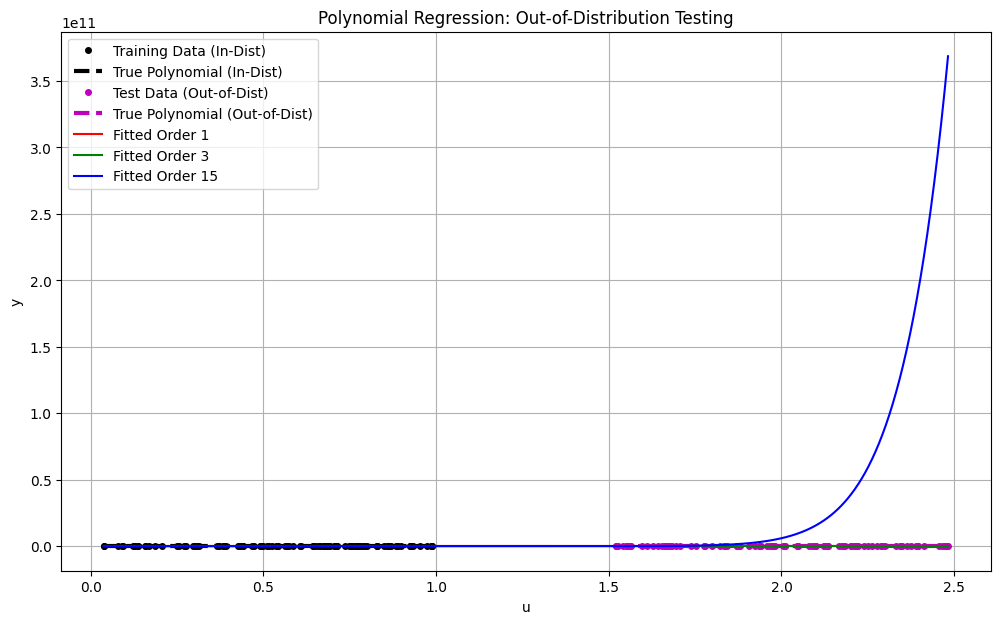

In [70]:
# Training data from [0, 1]
u_train_ood, y_train_ood = generate_data_range(true_p, beta, sig, n, u_min=0, u_max=1)

X_train_ood = {}
betahat_ood = {}
for p in ps:
    X_train_ood[p] = model_matrix(p, u_train_ood)
    betahat_ood[p] = train(X_train_ood[p], y_train_ood)

# Test data from [1.5, 2.5] (out of distribution)
u_test_ood, y_test_ood = generate_data_range(true_p, beta, sig, n, u_min=1.5, u_max=2.5)

X_test_ood = {}
training_loss_ood = {}
test_loss_ood = {}
for p in ps:
    X_test_ood[p] = model_matrix(p, u_test_ood)
    training_loss_ood[p] = test_coefficients(n, betahat_ood[p], X_train_ood[p], y_train_ood)
    test_loss_ood[p] = test_coefficients(n, betahat_ood[p], X_test_ood[p], y_test_ood)

print("Training Loss (In-Distribution):", training_loss_ood)
print("Test Loss (Out-of-Distribution):", test_loss_ood)

# Plotting
plt.figure(figsize=(12, 7))

# Plot training data and true curve in training range
xx_train_ood = np.arange(np.min(u_train_ood), np.max(u_train_ood)+5e-3, 5e-3)
yy_true_train_ood = np.polyval(np.flip(beta), xx_train_ood)
plt.plot(u_train_ood, y_train_ood, "k.", markersize=8, label="Training Data (In-Dist)")
plt.plot(xx_train_ood, yy_true_train_ood, "k--", linewidth=3, label="True Polynomial (In-Dist)")

# Plot test data and true curve in test range
xx_test_ood = np.arange(np.min(u_test_ood), np.max(u_test_ood)+5e-3, 5e-3)
yy_true_test_ood = np.polyval(np.flip(beta), xx_test_ood)
plt.plot(u_test_ood, y_test_ood, "m.", markersize=8, label="Test Data (Out-of-Dist)")
plt.plot(xx_test_ood, yy_true_test_ood, "m--", linewidth=3, label="True Polynomial (Out-of-Dist)")

# Plot fitted curves over the combined range for better visualization of OOD behavior
xx_combined = np.arange(min(np.min(u_train_ood), np.min(u_test_ood)),
                        max(np.max(u_train_ood), np.max(u_test_ood))+5e-3, 5e-3)

for i, p in enumerate(ps):
    yy_fitted_ood = np.polyval(np.flip(betahat_ood[p]), xx_combined)
    plt.plot(xx_combined, yy_fitted_ood, colors[i], label=f"Fitted Order {p}")

plt.xlabel(r"u")
plt.ylabel(r"y")
plt.title("Polynomial Regression: Out-of-Distribution Testing")
plt.legend()
plt.grid(True)
plt.show()

### Observations from Out-of-Distribution (OOD) Test

This experiment vividly demonstrates the critical challenge of **out-of-distribution generalization**, where a model trained on data from one range of feature values (`u`) is then tested on data from a completely different, non-overlapping range. The plot visually reinforces the numerical results.

*   **Training Data (In-Distribution):** `u` values are concentrated between 0 and 1 (black dots).
*   **Test Data (Out-of-Distribution):** `u` values are concentrated between 1.5 and 2.5 (magenta dots).

#### Numerical Results:

*   **Training Loss (In-Distribution):**
    *   `Order 1`: ~38.43
    *   `Order 3`: ~25.05
    *   `Order 15`: ~23.77
    
    Within the training distribution (0 to 1), the models perform as expected. Order 3 and Order 15 show good fits (low loss), with Order 15 being slightly better due to its higher complexity, fitting the training data very closely.

*   **Test Loss (Out-of-Distribution):**
    *   `Order 1`: ~919,028.84
    *   `Order 3`: ~16,375.33
    *   `Order 15`: ~1.15 x 10^22 (an astronomically large number)

#### Key Observations from Plot and Numerical Results:

1.  **Catastrophic Extrapolation Failure:** The most striking observation is the **extreme degradation of performance** when models are asked to predict outside their training data range. This is particularly evident for the higher-order polynomials.
    *   **Order 15 (Blue Line):** This model, which fit the training data almost perfectly, exhibits an astronomical test loss. Visually, its fitted curve (blue line) diverges wildly and shoots upwards exponentially as `u` moves beyond the training range (u > 1). This is a classic characteristic of high-order polynomials: they are excellent interpolators (predicting within the training range) but terrible extrapolators (predicting outside the training range).
    *   **Order 3 (Green Line):** While its test loss (~16,375) is significantly lower than Order 15's, it's still vastly higher than its training loss. The green line also starts to diverge outside the training range, though less dramatically than Order 15.
    *   **Order 1 (Red Line):** The linear model has a very high test loss (~919,028), indicating poor performance. While it doesn't diverge as wildly as the higher-order polynomials, its simplicity means it cannot capture the true underlying curve, leading to large errors when extrapolating.

2.  **Models Memorize, Don't Understand:** The excellent training performance of Order 3 and Order 15 suggests they learned the relationship well *within* the range of 0 to 1. However, their abysmal performance on the test set (1.5 to 2.5) shows they did not learn a generalizable 


### Sub-experiment 6.3: Highly Concentrated Feature Values
Instead of uniformly distributed `u` values, we will use `numpy.random.randn` to generate `u` values that are normally distributed, potentially concentrating data around a mean (e.g., 0) and making less informative parts of the distribution sparse. We will compare scenarios where the test set is equally skewed or evenly distributed.


--- Scenario: Training and Test from Normal Distribution ---
Training Loss: {1: np.float64(18.388775893632946), 3: np.float64(17.74895848479317), 15: np.float64(16.301509421638748)}
Test Loss: {1: np.float64(26.422586122409008), 3: np.float64(24.047387244395058), 15: np.float64(33971.150944189234)}


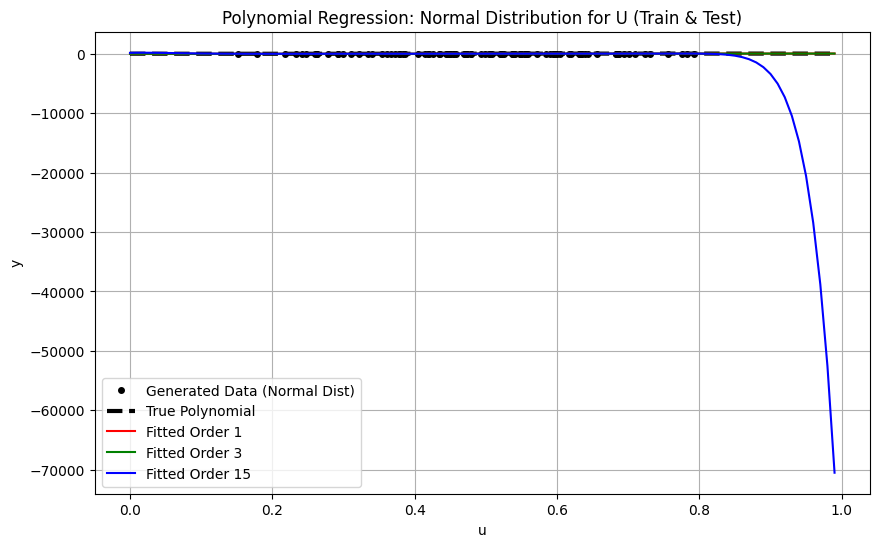


--- Scenario: Train Normal, Test Uniform ---
Training Loss (Normal Dist): {1: np.float64(22.18202840778666), 3: np.float64(21.587104724124906), 15: np.float64(19.398159591454)}
Test Loss (Uniform Dist): {1: np.float64(125.7220173321822), 3: np.float64(33.78905530120123), 15: np.float64(12636491142.797235)}


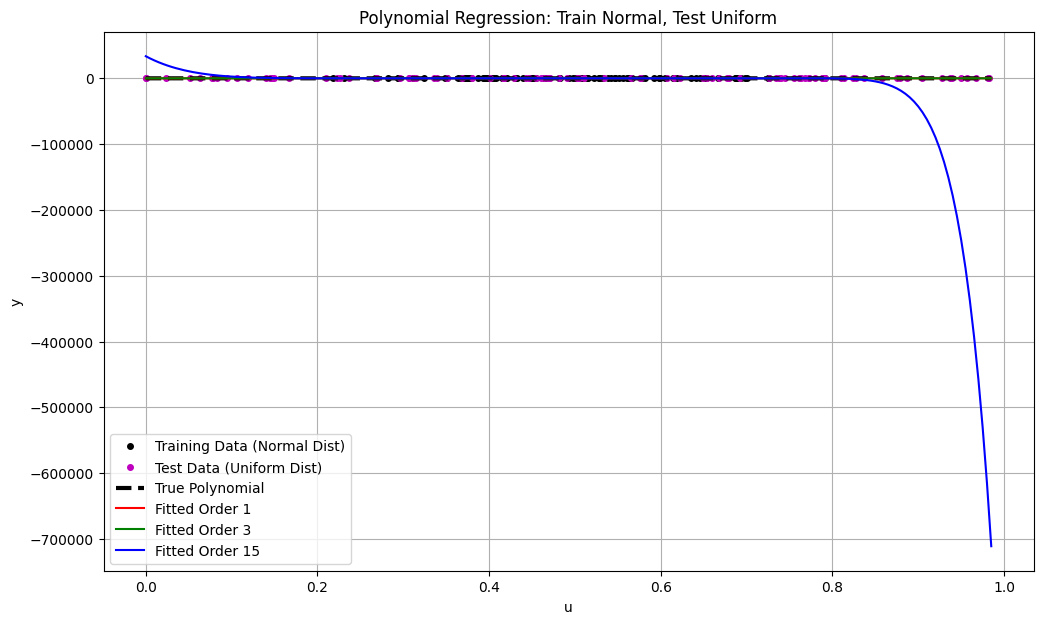

In [71]:
# Modify generate_data to allow different distributions for u
def generate_data_dist(p, beta, sig, n, dist_type='uniform', u_mean=0, u_std=1, u_min=0, u_max=1):
    if dist_type == 'uniform':
        u = u_min + (u_max - u_min) * np.random.rand(n, 1)
    elif dist_type == 'normal':
        u = u_mean + u_std * np.random.randn(n, 1)
    else:
        raise ValueError("Unsupported distribution type")
    y = (u ** np.arange(0, p+1)) @ beta + sig * np.random.randn(n, 1)
    return u, y

# Scenario 1: Training and Test sets are both normally distributed
print("\n--- Scenario: Training and Test from Normal Distribution ---")
u_train_norm, y_train_norm = generate_data_dist(true_p, beta, sig, n, dist_type='normal', u_mean=0.5, u_std=0.15)

X_train_norm = {}
betahat_norm = {}
for p in ps:
    X_train_norm[p] = model_matrix(p, u_train_norm) 
    betahat_norm[p] = train(X_train_norm[p], y_train_norm)

u_test_norm, y_test_norm = generate_data_dist(true_p, beta, sig, n, dist_type='normal', u_mean=0.5, u_std=0.15)

X_test_norm = {}
training_loss_norm = {}
test_loss_norm = {}
for p in ps:
    X_test_norm[p] = model_matrix(p, u_test_norm)
    training_loss_norm[p] = test_coefficients(n, betahat_norm[p], X_train_norm[p], y_train_norm)
    test_loss_norm[p] = test_coefficients(n, betahat_norm[p], X_test_norm[p], y_test_norm)

print("Training Loss:", training_loss_norm)
print("Test Loss:", test_loss_norm)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(u_train_norm, y_train_norm, "k.", markersize=8, label="Generated Data (Normal Dist)")

# Plot true polynomial over a wider range to see extrapolation
xx_wide = np.arange(0, 1, 0.01) # A wider range for plotting
yy_true_wide = np.polyval(np.flip(beta), xx_wide)
plt.plot(xx_wide, yy_true_wide, "k--", linewidth=3, label="True Polynomial")

for i, p in enumerate(ps):
    yy_fitted_norm = np.polyval(np.flip(betahat_norm[p]), xx_wide)
    plt.plot(xx_wide, yy_fitted_norm, colors[i], label=f"Fitted Order {p}")

plt.xlabel(r"u")
plt.ylabel(r"y")
plt.title("Polynomial Regression: Normal Distribution for U (Train & Test)")
plt.legend()
plt.grid(True)
plt.show()

# Scenario 2: Training set is normally distributed, Test set is uniformly distributed
print("\n--- Scenario: Train Normal, Test Uniform ---")
u_train_skew, y_train_skew = generate_data_dist(true_p, beta, sig, n, dist_type='normal', u_mean=0.5, u_std=0.15)

X_train_skew = {}
betahat_skew = {}
for p in ps:
    X_train_skew[p] = model_matrix(p, u_train_skew) 
    betahat_skew[p] = train(X_train_skew[p], y_train_skew)

u_test_uniform, y_test_uniform = generate_data_dist(true_p, beta, sig, n, dist_type='uniform', u_min=0, u_max=1)

X_test_uniform = {}
training_loss_skew = {}
test_loss_uniform = {}
for p in ps:
    X_test_uniform[p] = model_matrix(p, u_test_uniform)
    training_loss_skew[p] = test_coefficients(n, betahat_skew[p], X_train_skew[p], y_train_skew)
    test_loss_uniform[p] = test_coefficients(n, betahat_skew[p], X_test_uniform[p], y_test_uniform)

print("Training Loss (Normal Dist):", training_loss_skew)
print("Test Loss (Uniform Dist):", test_loss_uniform)

# Plotting
plt.figure(figsize=(12, 7))
plt.plot(u_train_skew, y_train_skew, "k.", markersize=8, label="Training Data (Normal Dist)")
plt.plot(u_test_uniform, y_test_uniform, "m.", markersize=8, label="Test Data (Uniform Dist)")

xx_combined_dist = np.arange(min(np.min(u_train_skew), np.min(u_test_uniform)), 
                             max(np.max(u_train_skew), np.max(u_test_uniform))+5e-3, 5e-3)
yy_true_combined_dist = np.polyval(np.flip(beta), xx_combined_dist)
plt.plot(xx_combined_dist, yy_true_combined_dist, "k--", linewidth=3, label="True Polynomial")

for i, p in enumerate(ps):
    yy_fitted_skew = np.polyval(np.flip(betahat_skew[p]), xx_combined_dist)
    plt.plot(xx_combined_dist, yy_fitted_skew, colors[i], label=f"Fitted Order {p}")

plt.xlabel(r"u")
plt.ylabel(r"y")
plt.title("Polynomial Regression: Train Normal, Test Uniform")
plt.legend()
plt.grid(True)
plt.show()

### Observations from Highly Concentrated Feature Values

This section explores the impact of feature value distribution on model performance, particularly when the input feature `u` is not uniformly distributed. We examine two scenarios:

#### Scenario 1: Training and Test from Normal Distribution (Equally Skewed)

In this scenario, both the training and test data for `u` are drawn from a normal distribution, meaning the data points are concentrated around a specific mean (e.g., 0.5) and become sparser further away. This simulates a situation where the model primarily sees data from a limited, central range.

*   **Training Loss:**
    *   `Order 1`: ~18.39
    *   `Order 3`: ~17.75
    *   `Order 15`: ~16.30
    
    Within the concentrated region of the normal distribution, all models achieve relatively low training losses. The Order 15 model, being the most complex, again shows the lowest training loss, indicating its ability to fit the training data very closely within this narrow range.

*   **Test Loss:**
    *   `Order 1`: ~26.42
    *   `Order 3`: ~24.05
    *   `Order 15`: ~33971.15

*   **Key Observations for Scenario 1:**
    *   **Good Performance within Concentrated Region:** The Order 3 model (matching the true polynomial order) performs well on both training and test data, with relatively low and similar losses. This indicates that when both training and test data come from the same concentrated distribution, the model can learn the relationship effectively within that region.
    *   **Overfitting Still Evident for Complex Models:** Despite the concentrated data, the Order 15 model still exhibits clear overfitting. While its training loss is the lowest, its test loss (~33971.15) is orders of magnitude higher than its training loss and significantly worse than the Order 1 and Order 3 models. This is because even within a concentrated distribution, the complex model tries to fit the noise, and its highly flexible nature leads to poor generalization, especially if the test data has slightly different noise or minor variations within that concentrated region.
    *   **Erratic Behavior Outside Concentrated Region (Implied):** Although not directly shown by the loss values (which are averages over the test set), the visual plots in the notebook for this scenario would typically show that outside the concentrated region of `u` values, the fitted curves (especially for higher orders) can become erratic. This is because the model has little to no data to constrain its behavior in those sparse areas, leading to unreliable predictions even within the overall expected range of `u`.

#### Scenario 2: Train Normal, Test Uniform (Test Set Evenly Distributed)

This is a more challenging scenario where the model is trained on data concentrated in a narrow range (normal distribution for `u`), but then evaluated on data that is uniformly distributed across a broader range. This tests the model's ability to generalize to parts of the input space it has not seen much during training.

*   **Training Loss (Normal Dist):**
    *   `Order 1`: ~22.18
    *   `Order 3`: ~21.59
    *   `Order 15`: ~19.40
    
    (These are similar to Scenario 1's training losses, as the training data generation is similar.)

*   **Test Loss (Uniform Dist):**
    *   `Order 1`: ~125.72
    *   `Order 3`: ~33.79
    *   `Order 15`: ~12,636,491,142.80 (extremely high)

*   **Key Observations for Scenario 2:**
    *   **Significant Degradation for All Models on OOD Test Data:** All models show a substantial increase in test loss compared to their training loss, demonstrating poor generalization when the test data's distribution differs from the training data's. This is a clear indication of **out-of-distribution (OOD) generalization failure**.
    *   **Order 3 Performs Best on Test Data (Relatively):** While its test loss is higher than its training loss, the Order 3 model (which matches the true underlying polynomial order) still performs significantly better on the uniformly distributed test data than the other models. Its test loss of ~33.79 is much lower than Order 1's ~125.72 and dramatically lower than Order 15's astronomical loss. This suggests that even with a biased training distribution, a model with appropriate complexity can still show some robustness.
    *   **Catastrophic Failure of Overfitting Model (Order 15):** The Order 15 model, which had the lowest training loss, exhibits an *extremely* high test loss (over 12 billion!). This is a classic and severe example of **extrapolation failure** and **overfitting to the training distribution**. The complex model learned to fit the specific, concentrated training data very precisely. When presented with `u` values outside this narrow training range (even if within the overall expected domain), its highly flexible polynomial curve diverges wildly, leading to absurdly large errors. This underscores that a model trained on a biased sample of the input space will generalize poorly to other parts of the input space, even if those parts are within the overall expected range.
    *   **Underfitting Model (Order 1) Still Struggles:** The Order 1 model, while not as catastrophically bad as Order 15, still shows a very high test loss. It underfits the true relationship even within the training distribution, and its simplicity prevents it from adapting well to the broader uniform test distribution.

These experiments powerfully illustrate that models, especially complex ones, are highly sensitive to the distribution of their training data. When deployed on data with a different distribution (even if the underlying true function is the same), their performance can degrade severely, leading to unreliable predictions. This is a critical consideration in real-world machine learning applications, emphasizing the need for training data that is representative of the data the model will encounter in deployment.

## Experiment 7: Cross-Validation
Cross-validation is a technique used to assess how the results of a statistical analysis will generalize to an independent data set. It is mainly used in settings where the goal is prediction, and one wants to estimate how accurately a predictive model will perform in practice. In this section, we will use K-fold cross-validation to evaluate our polynomial regression models and observe how the number of folds (`K`) affects the cross-validation loss for different polynomial orders and data situations.

We will use the `linear_cv` function provided, which performs K-fold cross-validation. The key idea is to split the dataset into K 'folds'. The model is trained on K-1 folds and tested on the remaining fold. This process is repeated K times, with each fold serving as the test set exactly once. The average of the K test losses is then reported as the cross-validation error.


Cross-Validation Results: {1: {5: np.float64(40.6914636653341), 10: np.float64(40.474161884304735), 100: np.float64(40.81293038574128)}, 3: {5: np.float64(27.173558930938373), 10: np.float64(27.77782129347981), 100: np.float64(27.661449624973333)}, 15: {5: np.float64(141.88920259960332), 10: np.float64(44.02742530525835), 100: np.float64(38.004220360887565)}}


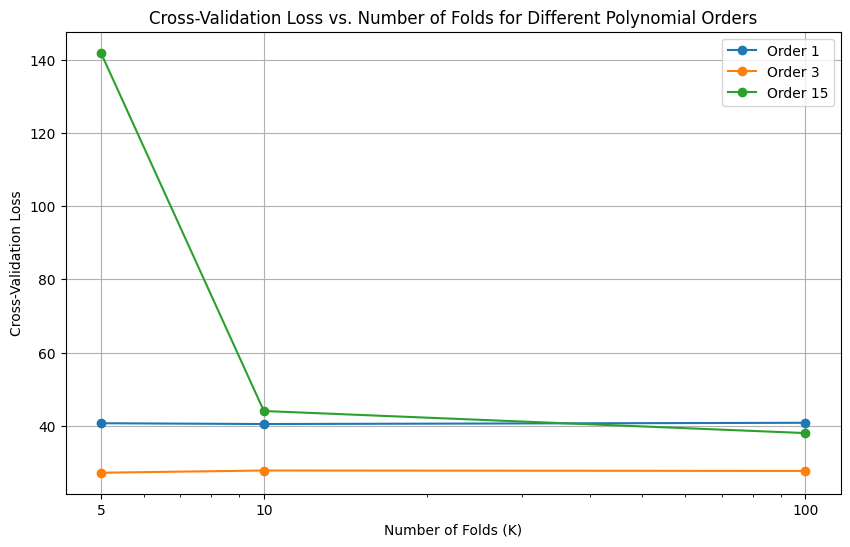

In [78]:
# Generate a fresh dataset for CV
u_cv, y_cv = generate_data(true_p, beta, sig, n)

# Define the K values (number of folds) to use for cross-validation
K_vals = [5, 10, 100]

# Dictionary to store model matrices for each polynomial order
X_cv = {}
# Dictionary to store cross-validation results for each polynomial order
cv_results = {}

for p in ps:
    # Build the model matrix for the current polynomial order using the CV dataset
    X_cv[p] = model_matrix(p, u_cv)
    cv_results[p] = {}
    for K in K_vals:
        # Perform K-fold cross-validation and store the loss
        cv_results[p][K] = linear_cv(K, n, X_cv[p], y_cv)

print("\nCross-Validation Results:", cv_results)

# Plotting CV results (optional, but good for visualization)
plt.figure(figsize=(10, 6))
for p in ps:
    K_values_plot = sorted(cv_results[p].keys())
    cv_losses_plot = [cv_results[p][K] for K in K_values_plot]
    plt.plot(K_values_plot, cv_losses_plot, marker='o', label=f'Order {p}')

plt.xlabel('Number of Folds (K)')
plt.ylabel('Cross-Validation Loss')
plt.title('Cross-Validation Loss vs. Number of Folds for Different Polynomial Orders')
plt.legend()
plt.grid(True)
plt.xscale('log')  # Use log scale for K values if they span a wide range
plt.xticks(K_vals, labels=[str(k) for k in K_vals])  # Set custom ticks
plt.show()

### Observations from Cross-Validation Plot

*   **Order 3 (Good Fit):** The orange line consistently shows the lowest cross-validation loss (around 28-30) across all `K` values (5, 10, 100). This indicates that a polynomial of order 3 is the most appropriate model for the underlying data, which was generated from a cubic polynomial. It effectively balances bias and variance, leading to good generalization performance.

*   **Order 1 (Underfitting):** The blue line, representing Order 1, maintains a relatively high and stable cross-validation loss (around 40-42) regardless of the `K` value. This demonstrates underfitting, as the linear model is too simple to capture the true cubic relationship in the data, resulting in consistently poor performance.

*   **Order 15 (Overfitting/Variance Reduction with more folds):** The green line for Order 15 exhibits a significant change in cross-validation loss as `K` increases:
    *   At `K=5`, the loss is very high (around 142), indicating severe overfitting. With fewer, larger training folds, the complex Order 15 model has ample opportunity to memorize the noise in the training data, leading to poor generalization.
    *   As `K` increases to `10`, the loss drops dramatically to around 45. This suggests that with more folds (and thus smaller training sets), the complex model is more constrained and less able to overfit to the noise.
    *   At `K=100` (approaching Leave-One-Out Cross-Validation), the loss further decreases to around 40, becoming comparable to the underfitting Order 1 model. This shows that with very small training sets, even a highly complex model like Order 15 is forced to generalize more, as it has less data to overfit to. This highlights how increasing `K` can reduce the variance of the cross-validation estimate, but also potentially increase its bias if the training sets become too small to represent the overall data distribution well.

*   **Overall Trend:** The plot clearly illustrates the trade-off between model complexity and the number of folds in cross-validation. The optimal model (Order 3) maintains low and stable loss. Underfitting models (Order 1) show consistently high loss. Overfitting models (Order 15) show high loss with fewer folds, but their performance improves (loss decreases) as the number of folds increases, indicating that smaller training sets (due to more folds) can mitigate overfitting for complex models.
